In [91]:
import pandas as pd
import nltk
import gzip
import re, string
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import random 
from matplotlib import pyplot
from pylab import rcParams
from wordcloud import WordCloud
from IPython.display import HTML, display
import matplotlib.patches as mpatches
import urllib
from IPython.display import Image, HTML

rcParams['figure.figsize'] = 15, 10
np.random.seed(42)
sns.set_context("poster")

**NB:**
- To visualize our data we used <a href="https://seaborn.pydata.org/index.html">`Seaborn`</a>: `pip install seaborn`
- To extract bigrams we used <a href="https://pypi.python.org/pypi/nltk">`NLTK`</a>: `pip install nltk`.
- To analyse the sentiments we used <a href="https://pypi.python.org/pypi/scikit-learn/0.19.1">`SKLearn`</a>: `pip install scikit-learn` 
- To visualize the word could we used <a href="https://pypi.python.org/pypi/wordcloud">`Wordcloud`</a>: `pip install wordcloud` 

# Introduction

In this notebook, we will explore opinion mining and sentiment analysis through the use of natural language processing. Our dataset consists of reviews of electronic products scraped form Amazon and available here: http://jmcauley.ucsd.edu/data/amazon/

The objective of this analysis is to use the reviews to extract meaningful characteristics about their respective product. Such characteristics can then be used to help the user make faster and more informed decisions when shopping on electronic commerce websites. The extracted characteristics consist of pairs of words that describe a property of the product such as its quality or performance. Those pairs are either of the type adjective-noun, adverb-past participle or verb-adverb.

For example:

    Adjective - Nouns: (good, quality) (low, price) (best, deal)
    Adverb - Past Participle: (well, made) (poorly, assembled)
    Verb - Adverb: (works, well) (runs, great)

The characteristics can then be segmented into positive and negative ones. This way, users can quickly be informed on the general trends and opinions formulated by previous clients about a particular product. Towards the end of the notebook we will see how we can aggregate product properties by brand and what are the predominant characteristics that the users associate with those brands.

## Table of Contents

<ol>
<li> <a href="#Data-Overview">Data Overview</a>
    <ol>
        <li><a href="#Reading-the-data">Reading the data</a></li>
        <li><a href="#Formats">Formats</a></li>
        <li><a href="#Missing-values">Missing values</a></li>
        <li><a href="#Distributions">Distributions</a></li>
    </ol>
</li>
<p></p>
<li> <a href="#Impressions-and-characteristics-extraction">Impressions and characteristics extraction</a></li>
<p></p>
<li><a href="#Sentiment-Analysis">Sentiment Analysis</a></li>
<p></p>
        <li><a href="#Sentiment-Analysis,-revisited">Sentiment Analysis, revisited</a></li>
<p></p>
<li><a href="#Application-to-brand-names">Application to brand names</a></li>
<li><a href="#Possible-improvements">Possible Improvements</a></li>
<li><a href="#Conclusion">Conclusion</a></li>
</ol>

# Reading the data 
**<a href="#Table-of-Contents">Back to table of contents</a>**

We will be using the following datasets:

1. Sample of electronic review (1,689,188 reviews)
2. Full dataset metadata

#### 1. Electronic reviews sample
Those easily fit in memory. Therefore, we can read the data line by line and store the result in a dataframe.
#### 2. Full dataset metadata
The metadata was downloaded from the cluster. It is not possible to load it in memory as when uncompressed it is more than 10GB in size. Since we care about electronic products for the moment, we read it line by line and only store the entries whose category is related to electronics. This results in a much smaller file of approximately 500Mo (uncompressed) which can hold in memory.

## Scalability
We argue that processing the data locally scales reasonably well to the review set as our pipeline is applied separately for each product. That is, strictly speaking, we only need to hold the reviews of one product as well as its metadata in memory at any given time. In the characteristics extraction step of this notebook, we identify the bottleneck of our pipeline in terms of performance. However, we propose a parallelized solution which is able to treat the whole electronics review dataset in about half an hour on a laptop processor which is reasonable given the size of the dataset.

## Code

### Reading the data file
To open the data file we reuse the python code given by the author of the dataset. (See http://jmcauley.ucsd.edu/data/amazon/)

In [2]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)
        
def parseUncompressed(path):
    g = open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    """
    Reads a data file and use it the build a DataFrame
    """
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

### Reading the metadata file

In [3]:
def metadata_for_category(path, category):
    """
    Reads the metadata file and extract only metadata for the given category
    path: The path to the metadata file
    category: The product category for which to extract the metadata
    
    Returns a DataFrame holding the metadata
    """
    i = 0
    df = {}
    for d in parseUncompressed(path):
        if 'categories' in d:
            for categories_list in d['categories']:
                if categories_list[0] == category:
                    df[i] = d
                    i += 1
    return pd.DataFrame.from_dict(df, orient='index')

### Loading and storing intermediate results
DataFrames' `to_pickle` and `read_pickle` are used to respectively save and load serialized version of our intermediate results. We use it for example to store only the Electronics metadata:

In [ ]:
df = metadata_for_category('data/metadata.json', 'Electronics')
df.to_pickle('data/metadata_electronics_serialized.pickle')

In [ ]:
df = getDF('data/reviews_Electronics_5.json.gz')
df.to_pickle('data/electronics_serialized.pickle')

# Data Overview
**<a href="#Table-of-Contents">Back to table of contents</a>**

We start by performing some basic statistical analysis on our data. By doing this, we seek to find if there are any unusual patterns which could be interesting in the context of our analysis.

In [4]:
df_elec = pd.read_pickle('data/electronics_serialized.pickle')

In [5]:
df_meta = pd.read_pickle('data/metadata_electronics_serialized.pickle')

### Formats
**<a href="#Table-of-Contents">Back to table of contents</a>**

We take a look the different formats contained in the DataFrame:

In [6]:
df_elec['reviewTime']  = pd.to_datetime(df_elec['reviewTime'],format='%m %d, %Y')
df_elec.dtypes

overall                  float64
reviewTime        datetime64[ns]
reviewerID                object
reviewText                object
summary                   object
unixReviewTime             int64
asin                      object
reviewerName              object
helpful                   object
dtype: object

* summary: The summary of the product
* reviewerName: The reviewer name
* reviewTime: The review time in the datetime type
* overall: The rating of the product from 1 to 5 included
* asin: The id of the product
* helpfull: The helpfulness of the comment. It is stored as an array; the first element is the number of positive votes the second element is the total number of votes for the comment.
* unixReviewTime: The review time in the unix format
* reviewerID: The reviewer id
* reviewText: The text of the review

In [7]:
df_meta = df_meta[pd.notnull(df_meta['brand'])]
df_meta.dtypes

description     object
asin            object
imUrl           object
title           object
categories      object
price          float64
salesRank       object
related         object
brand           object
dtype: object

* title: The name of the product
* description: The description of the product
* imUrl: The url of the image
* categories: The categories of the product, stored as an array
* asin: The id of the product
* price: The price of the product
* selesRank: The sales rank, stored as dictionary mapping the category to the rank
* related: The related products, stored as dictionary mapping a tag (also_bought, bought_together,...) to the asin
* brand: The name of the brand

### Missing values
**<a href="#Table-of-Contents">Back to table of contents</a>**

To plot the data, we discarded every null entries in price and reviewLength.

In [9]:
df_merged = df_meta.merge(df_elec, left_on='asin', right_on='asin', how='inner')
df_merged['reviewLength'] = df_merged['reviewText'].str.len()

df_plot = df_merged.copy()
df_plot = df_plot[pd.notnull(df_plot['price'])]
df_plot = df_plot[pd.notnull(df_plot['reviewLength'])]

### Distributions
**<a href="#Table-of-Contents">Back to table of contents</a>**

We plotted the scatter matrix of the price, the review length and the overall score, to visualize the global distribution of the data:

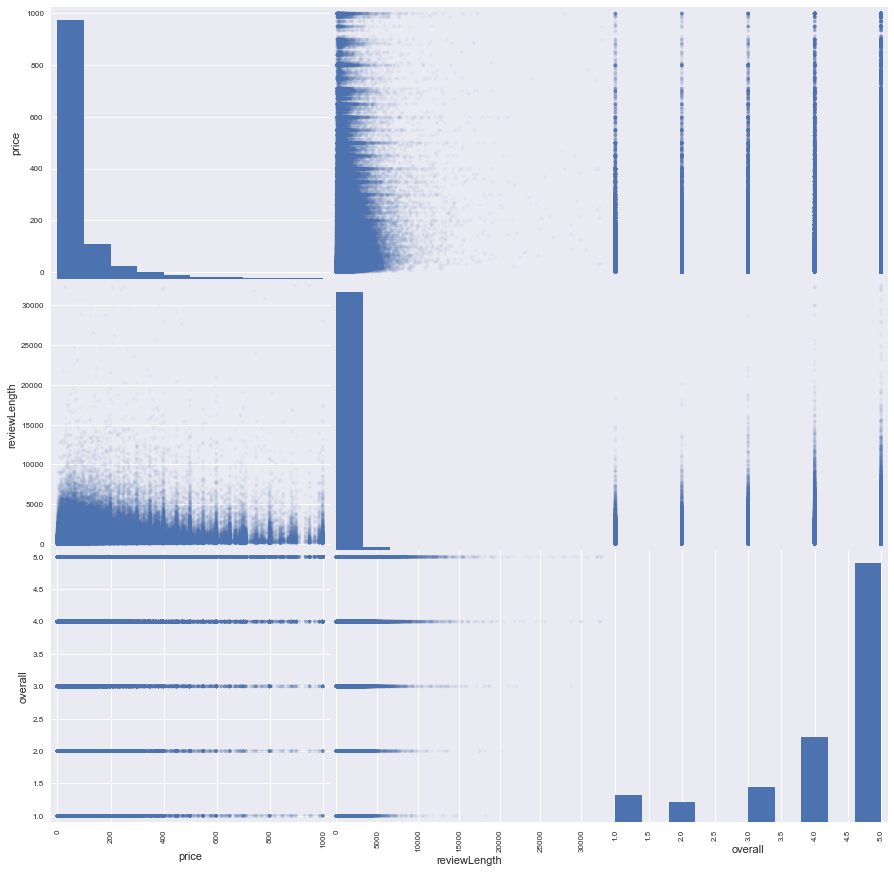

In [139]:
from pandas.plotting import scatter_matrix
import matplotlib

sns.set(font_scale = 1)
scatter_matrix(df_plot[['price','reviewLength','overall']], alpha=0.05, figsize=(15, 15), diagonal='hist')
plt.show()

We also plotted the price over the review length to see in more details the data. We can directly see that there is a lot of noise (as expected). We also see that most of the mass is concentrated in a rather small interval; indeed the median of the price is 28.5 and the median of the text length is 312.

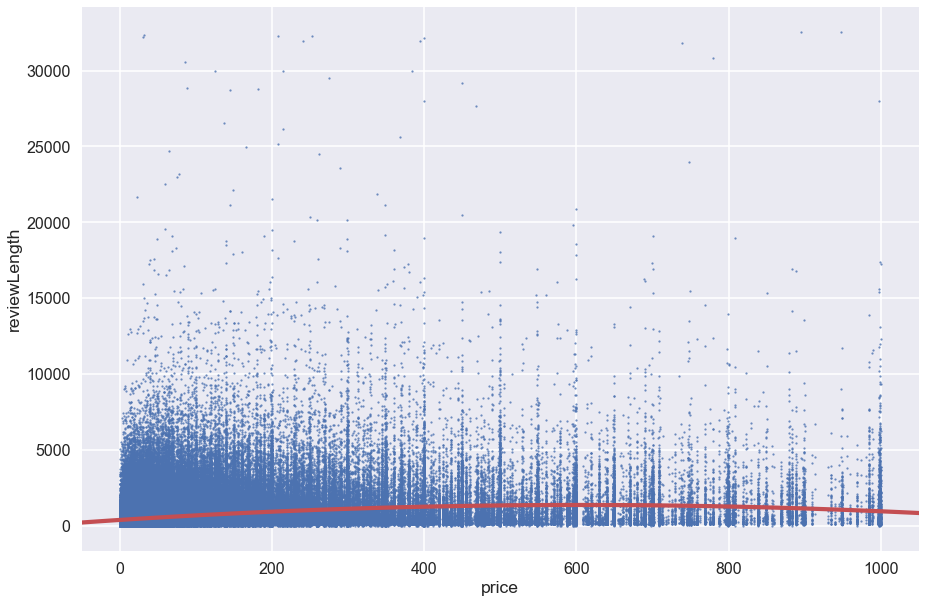

In [10]:
sns.regplot(y='reviewLength', x='price', data=df_plot,scatter_kws={'s':5},line_kws={'color':'r'},order=2)
plt.show()

We also plotted the distributions of the reviewLength over the overall rating. We can see that the extremes are less present in the data. Indeed, the review length is smaller for good reviews, this can be explained by the fact those reviews are synthetic: “Well made”, “Good Product”. The reviews that have a bad score (2) tend to be larger, as the critic can be quite extensive.

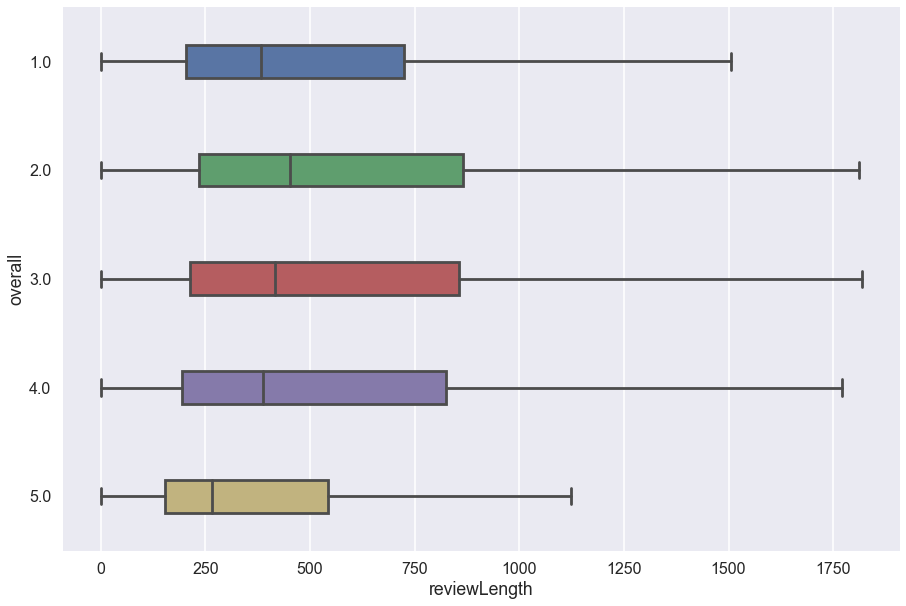

In [85]:
sns.boxplot(y='overall', x='reviewLength', data=df_plot, orient='h', showfliers=False, width=0.3)
plt.show()

Finally, we sought to understand the distribution of the price and the review length by plotting their density and the box plot.

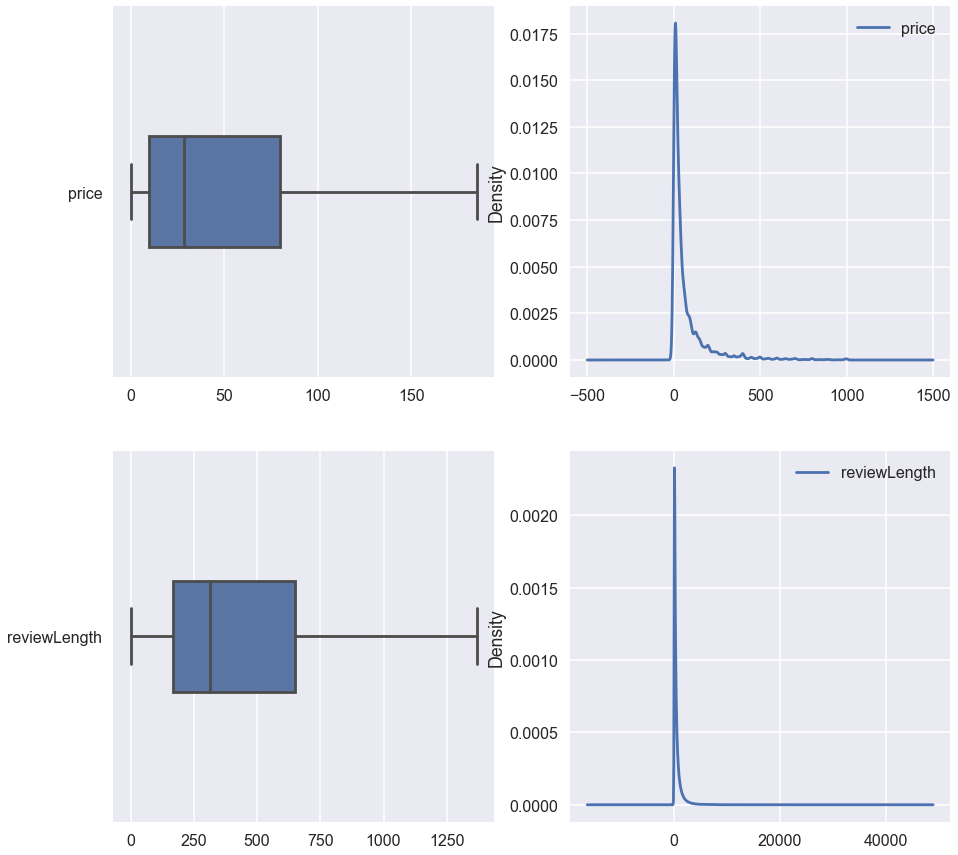

In [88]:
f, axes = plt.subplots(2, 2, figsize=(15, 15))
sns.boxplot(data= df_plot[['price']],orient='h', showfliers=False,ax=axes[0,0], width=0.3)
df_plot[['price']].plot.kde(ax=axes[0,1])
sns.boxplot(data= df_plot[['reviewLength']],orient='h', showfliers=False,ax=axes[1,0], width=0.3)
df_plot[['reviewLength']].plot.kde(ax=axes[1,1])

plt.show()

We tried to fit a specific distribution; the exponential distribution to the data provided. We see that if we pick lambda = 65, we get a close approximation to the result.

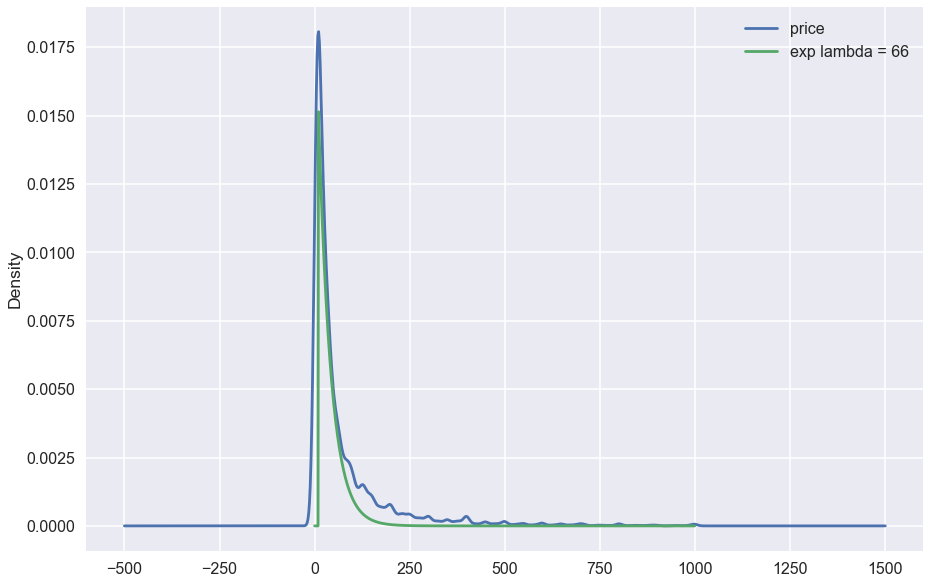

In [13]:
from scipy.stats import expon
import scipy.stats

d = df_plot[['price']]
ax = d.plot.kde()
x = ax.get_children()[0]._x
y = ax.get_children()[0]._y

scale = 66
loc = -480

pdf_fitted = expon.pdf(x - loc, scale=scale)
plt.plot(pdf_fitted,label= ('exp lambda = ' + str(scale)))
plt.legend(loc='best')
plt.show()

We tried to fit a specific distribution; the pareto distribution to the data provided. We see that if we pick b = 1, we get a close approximation to the result up to a multiplicative constant.

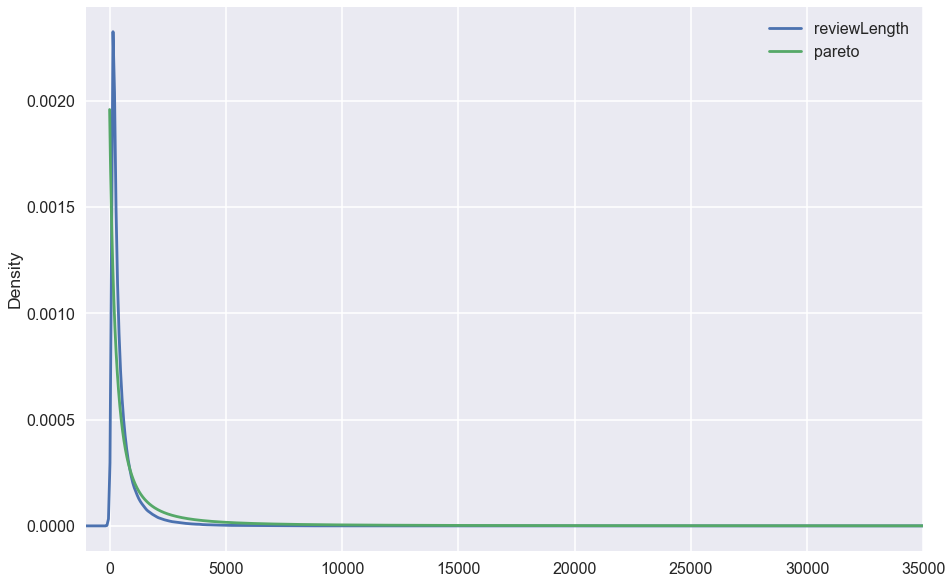

In [14]:
from scipy.stats import pareto
import scipy.stats

d = df_plot[['reviewLength']]
ax = d.plot.kde()
ax.set_xlim(left= -1000,right = 35000)

b = 1
x = np.linspace(pareto.ppf(0.01, b),pareto.ppf(0.99, b), 50000)
pdf_fitted = scipy.stats.pareto.pdf(x,b = b)/500
plt.plot(pdf_fitted,label= 'pareto')
plt.legend(loc='best')
plt.show()

We now display the Q-Q plot of the pareto distribution and of our data:

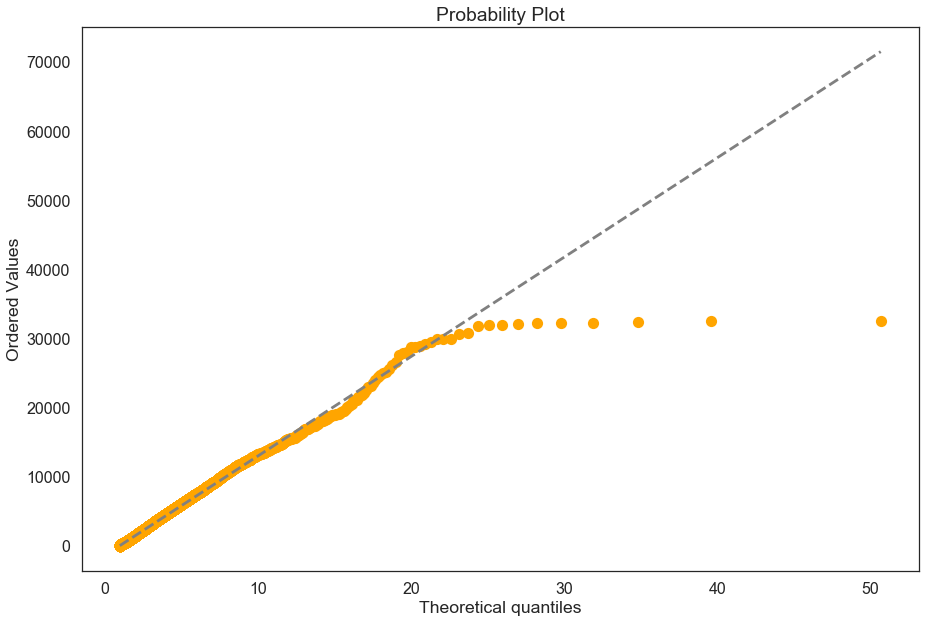

In [15]:
sns.set_style("ticks")
sns.set_style("white")

ax = plt.subplot()
d = df_plot[['reviewLength']].values.flatten()

scipy.stats.probplot(x = d, dist=pareto, sparams=(3.6,),plot=ax)

ax.get_lines()[0].set_markerfacecolor('orange')
ax.get_lines()[1].set_color('grey')
ax.get_lines()[1].set_linestyle('--')

plt.show()

The Q-Q plot clearly emphasizes the limit of 5000 words set by Amazon on review lengths. 30k characters limit seems very plausible since the average word length in English is 5 letters and that there are spaces between each words.

### Correlations

We computed the correlation between the price, reviewLength, and the overall. We can see that the overall doesn't seem to be a lot correlated between the price and the review length. But more interestingly there seem to be some correlation between the price and the review lenght. Maybe the users are more passionate about the items they are willing to spend more money on !

In [16]:
df_merged[['price','reviewLength','overall']].corr()

,price,reviewLength,overall
price,1.000000,0.249120,0.025969
reviewLength,0.249120,1.000000,-0.076393
overall,0.025969,-0.076393,1.000000


# Impressions and characteristics extraction
**<a href="#Table-of-Contents">Back to table of contents</a>**

Now that we have acquired basic insight on our data, we will dive into the core of the project. We will start by extracting basic reviewers impressions on a product. We define impressions as adjectives that appear frequently in the reviews. Typical examples would be adjectives such as "great", "good" or "excellent". 

Adjectives alone are a good way of quickly extracting an impression on a product. However, they do not offer any context. Indeed, suppose that a laptop turns out to receive multiple times the adjective "good". What exactly is considered by the users as good in this product ? Is it the image quality of the screen, the price or its performances ? We therefore want to be able to extract product characteristics from reviews. One simple and effective way of doing that is to find collocations of adjective-nouns pairs. Collocations are tuples of words that happen more frequently together than one would expect if they were distributed randomly in the text.

As explained in the introduction, we will extract pairs, also knowns as bigrams, consisting of Adjective-Nouns (like "good quality"), Adverb - Past Participle (like "well made") and verb-adverb (like "works well").

## Identifying parts-of-speech (PoS)

Parts-of-speech are categories of words that exhibit similar grammatical properties such as adjectives, adverbs and verbs. To be able to identify the various categories that we will need for our analysis, we use the [Natual Language Tool Kit (NLTK)](http://www.nltk.org/) package for Python. NLTK is capable of returning PoS tags for any given word. The nomenclature chosen for those tags is taken from the [Penn Treebank Project](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf). The tags used by our pipeline will be the following:

Every tag starting with *JJ*: 
* JJ -	Adjective
* JJR -	Adjective, comparative
* JJS -	Adjective, superlative 

Every tag starting with *RB*:
* RB -	Adverb
* RBR - Adverb, comparative
* RBS - Adverb, superlative 
* VBN -	Verb, past participle 

Every tag starting with *NN*:
* NN -	Noun, singular or mass
* NNS -	Noun, plural
* NNP -	Proper noun, singular
* NNPS - Proper noun, plural 

Every tag starting with *VB*
* VB -	Verb, base form
* VBD -	Verb, past tense
* VBG -	Verb, gerund or present participle
* VBN -	Verb, past participle
* VBP -	Verb, non-3rd person singular present
* VBZ -	Verb, 3rd person singular present 

## Extracting impressions

For a reason that will become clear in a minute, we start by defining a function which is able to verify if a word is contained in a dictionnary:

In [17]:
compound_dictionnary = pd.read_pickle("data/filtered_compound_words.pickle.gz")

def is_compound_word(word):
    i = compound_dictionnary.searchsorted(word)

    if i == len(compound_dictionnary):
        return False

    x = compound_dictionnary.iloc[i].values
    return x[0] == word

Then we implement the adjective extraction function. We will feed to this function the result of concatenating all the review for a given product.

In [89]:
def isAdjective(token):
    """
    w: Tagged word

    Returns true if the part-of-speech is an adjective
    """
    _, tag = nltk.pos_tag([token])[0]

    return tag == 'JJ' or tag == 'JJS'


def getAdjectives(text):
    """
    text: The concatenation of all the review for a given product

    Returns the collocations of words larger 
    """

    pattern = re.compile('[\\\*\.]+')
    text = re.sub(pattern, " ", text)

    tokens = nltk.word_tokenize(text)

    adjectives = []

    for i, token in enumerate(tokens):

        # Extract adjectives
        if isAdjective(token):
            one_before = max(i - 1, 0)
            two_before = max(i - 2, 0)
            one_after = min(i + 1, len(tokens)-1)

            # Ignore compound words
            if not is_compound_word(tokens[i] + "_" + tokens[one_after]):
                # Identify negations
                if tokens[one_before] == 'not':
                    adjectives.append(tokens[one_before] + " " + tokens[i])
                elif tokens[two_before] == 'not':
                    adjectives.append(tokens[two_before] + " " + tokens[i])
                else:
                    adjectives.append(token)

    return Counter(adjectives).most_common(None)

We can now explain why we needed the filtering function. When the review aggregate is processed by the function, the overall string is decomposed into several words which we call tokens. Those tokens are kept only if their PoS tag is an adjective, JJ, or a superlative, JJS. However, there are words that will considered as adjectives while they actually are part of a compound word. One of the best example of this is the noun "hard drive". It will obviously appear with very high frequency on reviews dedicated to hard drives and our algorithm will pick up "hard", as "hard" is by itself an adjective. This is why we need to filter out cases in which the token is part of a compound word. The way we obtained this dictionnary deserves more explanation.

## Creating a dictionnary for filtering out tokens

Findind a list of modern english words is not an easy task. Almost every dataset that can be found on the internet does not include nouns relevant for our work (such as hard drive or optical mouse). There are some online APIs such as [Oxford Dictionnary API](https://developer.oxforddictionaries.com/) or [Words API](https://www.wordsapi.com/) which return very rich results but they are priced prohibitively high, in the hundreds of dollars for the use we would make of them.

But here comes Wikipedia to the rescue, or more precisely, Wiktionnary. Wiktionnary is a free to use and open online dictionnary with over five millions english words. The best part is that it contains all the words we are looking for and it can be downloaded in its entirety (just like Wikipedia). We selected the subset consisting only of the titles of the wiktionnary pages, as they are named according the word for which they provide a definition. The set of all titles can be downloaded [here](https://dumps.wikimedia.org/enwiktionary/latest/) under the name `enwiktionary-latest-all-titles-in-ns0.gz` where `ns0` denotes the zero namespace. This namespace contains all wikipedia articles (More information about wikipedia namespaces can be found [here](https://en.wikipedia.org/wiki/Wikipedia:Namespace).

Because we only need compound words, we will be able to greatly reduce the size of the wiktionary dataset:

In [19]:
wiki = pd.DataFrame.from_csv('data/enwiktionary-latest-all-titles-in-ns0', sep='\t').reset_index()

print(len(wiki))
# Normalize the representation of title
wiki.page_title = wiki.page_title.str.lower()

# Keep only compound words, spaces are represented using underscores
wiki = wiki[wiki.page_title.str.contains('_', na=False)]

# Remove garbage pages entered by the user by keeping only alphanumeric titles
wiki_filtered = wiki[wiki.page_title.str.contains("^[a-z_]+$", na=False, regex=True)]

# Remove entries which are not simple compound words
wiki_filtered = wiki_filtered[wiki_filtered.page_title.str.replace('[a-z]', '').apply(len) < 2]

compound_words = wiki_filtered.page_title
compound_words = compound_words.sort_values(ascending=True)
compound_words.head()
print(len(compound_words))

compound_words.to_pickle("data/filtered_compound_words.pickle.gz", compression='gzip')

5442799
156722


The few preprocessing steps above allow us to reduce the size of the dictionnary from 5 million down to ~200k entries. 

## Extracting characteristics

To extract collocations of type adjective-noun, adverb-past participle and verb-adverb we define a function that identifies if the bigram correspond to any of those interesting collocation types. It also checks that the bigram is not in a manually-defined blacklist and that the elements in the bigram does not make a compound word, for the same reasons as before). The blacklist is used to remove undesired bigrams appearing with high frequency such as "was able".

In [10]:
black_list_t1 = ['few', 'am', 'is', 'was', "'m", 'different', 'being', 'other', 'same', 'last', 'upper']
black_list_t2 = ['reviews', 'engineer', 'days', 'months', 'years']

def filterBigram(w1, w2):
    return  filterTags(w1, w2) and notInBlackList(w1, w2) and not is_compound_word(w1+"_"+w2)

def notInBlackList(w1, w2):
    return (w1 not in black_list_t1) and (w2 not in black_list_t2)

def filterTags(w1, w2):
    """
    w1: First tagged word
    w2: Second tagged word
    Returns true if the bigram collocation is of type adjective-noun, adverb-past participle or verb-adverb
    """
    _, tag1 = nltk.pos_tag(nltk.word_tokenize(w1))[0]
    _, tag2 = nltk.pos_tag(nltk.word_tokenize(w2))[0]

    return (tag1.startswith('JJ') and tag2.startswith('NN')) or \
           (tag1.startswith('RB') and tag2.startswith('VBN')) or \
           (tag1.startswith('VB') and tag2 == "JJ")
        
filterTags("worked","great")

True

### Raw frequencies vs. PMI vs. likelihood ratios

There exists several different metrics for finding interesting collocations. Raw bigram frequencies, point-wise mutual information (PMI) and ratio of likelihoods. 

PMI is defined as:
$$\textbf{PMI}(w_1,w_2) = \log\frac{p(w_1,w_2)}{p(w_1)\cdot p(w_2)} = \log\frac{p(w_2 | w_1)}{p(w_2)}$$
It measures the amount of information provided by the occurrence of event $w_1$ about the occurrence of event $w_2$. In our case, $p(w_1)$ and $p(w_2)$ represent the frequency of the words in the reviews and $p(w_1, w_2)$ represents the frequency of the sequence of the words. 

Ratio of likelihoods is defined as follows:
$$ L(w_1, w_2) = \log\frac{L(H_1)}{L(H_2)} $$
Where $H_1$ is the hypothesis that the occurrence of $w_2$ is independent of the previous occurrence of $w_1$, ie: $P(w_2|w_1) = P(w_2|\neg w_1)$, and $H_2$ the hypothesis that it is in fact dependent.

NLTK offers an interface for computing those metrics for a bigram given its text corpus (the aggregated reviews).

In the next cell we illustrate the differences in bigram rankings for those metrics. For a selection of five product we show side-by-side the ranking obtained by using likelihood ratios, point-wise mutual information and raw frequencies. The last column, hybrid, is a mix between likelihood and pmi.

In [45]:

c_raw = pd.read_pickle("data/elec_collocations_adjectives_experimental_rawfreq.pickle")
c_raw = c_raw.dropna(how = 'any')

c_pmi = pd.read_pickle("data/elec_collocations_adjectives_experimental_pmi.pickle")
c_pmi = c_pmi.dropna(how = 'any')

c_likelihood = pd.read_pickle("data/elec_collocations_adjectives_experimental_likelihood.pickle")
c_likelihood = c_likelihood.dropna(how = 'any')

c_hybrid = pd.read_pickle("data/elec_collocations_adjectives_hybrid.pickle")
c_hybrid = c_hybrid.dropna(how = 'any')

comparison = c_raw.merge(
    c_pmi, left_on='asin', right_on='asin', how='inner', suffixes=['_raw','_pmi']).merge(
    c_likelihood, left_on='asin', right_on='asin', how='inner').merge(
    c_hybrid, left_on='asin', right_on='asin', how='inner', suffixes=['_likelihood','_hybrid']
)

for id in df_elec.groupby(["asin"])['reviewText'].agg('count').sort_values(ascending=False).index[100:105]:
    raw = [tup[0] for tup in comparison[comparison.asin == id]["reviewText_raw"].values[0][:6]]
    pmi = [tup[0] for tup in comparison[comparison.asin == id]["reviewText_pmi"].values[0][:6]]
    likelihood = [tup[0] for tup in comparison[comparison.asin == id]["reviewText_likelihood"].values[0][:6]]
    hybrid = [tup[0] for tup in comparison[comparison.asin == id]["reviewText_hybrid"].values[0][:6]]
    comparison_data = {'raw' : raw, 'pmi' : pmi, 'likelihood':likelihood, 'hybrid':hybrid}
    display(pd.DataFrame(data=comparison_data))
    print(df_meta[df_meta.asin==id]['title'].values)

,hybrid,likelihood,pmi,raw
0,"(retail, packaging)","(is, good)","(retail, packaging)","(is, good)"
1,"(good, sound)","(is, great)","(fully, charged)","(is, great)"
2,"(fully, charged)","(positive, reviews)","(positive, reviews)","(good, sound)"
3,"(are, great)","(good, sound)","(same, company)","(are, great)"
4,"(highly, recommended)","(same, time)","(highly, recommended)","(are, comfortable)"
5,"(second, pair)","(are, great)","(next, song)","(great, sound)"


[ 'Motorola S305 Bluetooth Stereo Headset w/ Microphone (Black) - Retail Packaging']


,hybrid,likelihood,pmi,raw
0,"(clear, text)","(dual, band)","(clear, text)","(main, router)"
1,"(dual, band)","(main, router)","(local, temperature)","(was, easy)"
2,"(local, temperature)","(full, bars)","(external, antenna)","(is, easy)"
3,"(main, router)","(second, floor)","(dual, band)","(full, bars)"
4,"(external, antenna)","(strong, signal)","(hard, wire)","(is, great)"
5,"(full, bars)","(few, minutes)","(100-150, feet)","(was, able)"


[ 'Securifi Almond - (3 Minute Setup) Touchscreen Wireless Router / Range Extender']


,hybrid,likelihood,pmi,raw
0,"(heavy, duty)","(well, made)","(heavy, duty)","(well, made)"
1,"(well, made)","(high, quality)","(positive, reviews)","(is, great)"
2,"(highly, recommended)","(little, bit)","(highly, recommended)","(little, bit)"
3,"(high, quality)","(good, quality)","(13.3-inch, ultrabook)","(good, quality)"
4,"(13.3-inch, ultrabook)","(highly, recommended)","(several, times)","(is, good)"
5,"(little, bit)","(new, macbook)","(hard, shell)","(high, quality)"


['Case Logic LAPS-111 10 - 11.6 -Inch Chromebook/Netbook Sleeve (Black)']


,hybrid,likelihood,pmi,raw
0,"(reasonably, priced)","(same, time)","(reasonably, priced)","(is, small)"
1,"(well, made)","(other, devices)","(original, equipment)","(other, usb)"
2,"(original, equipment)","(well, made)","(high, quality)","(same, time)"
3,"(good, quality)","(is, small)","(electric, outlet)","(other, devices)"
4,"(high, quality)","(good, quality)","(electrical, outlet)","(is, good)"
5,"(electric, outlet)","(other, usb)","(being, able)","(is, great)"


[]


,hybrid,likelihood,pmi,raw
0,"(flat, screen)","(new, canon)","(flat, screen)","(great, price)"
1,"(new, canon)","(was, able)","(professional, photographer)","(is, great)"
2,"(professional, photographer)","(full, hd)","(negative, reviews)","(new, canon)"
3,"(full, hd)","(other, brands)","(sequential, read/write)","(was, able)"
4,"(sequential, read/write)","(most, people)","(high, res)","(full, hd)"
5,"(most, people)","(high, quality)","(last, week)","(good, price)"


[]


We see that in most cases, raw frequency retrieves very simple bigrams such as "good *something*", "great *something*" while probability-based techniques capture product features such as "flat screen" and "clear text".

We chose to use both pmi and likelihood metrics since in most of the cases they return different collocations and neither of those technique is consistently superior to the other. Therefore, we chose to retrieve the best collocations of each technique after filtering the bigrams with the black list.  

The core of the collocation extraction is shown below. As explained, we use both point-wise mutual information and ratios of likelihood. 

In [46]:

def getCollocations(text):
    """
    text: The concatenation of all the review for a given product
    Returns the collocations of words larger
    """
    print(text[:3])

    tokens = nltk.word_tokenize(text)
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = nltk.BigramCollocationFinder.from_words(tokens)

    # Ignore bigram that are infrequent
    finder.apply_freq_filter(3)

    bigram_res_likelihood = finder.nbest(bigram_measures.likelihood_ratio, None)
    bigram_res_pmi = finder.nbest(bigram_measures.pmi, None)

    res_likelihood = [(x, round(finder.score_ngram(bigram_measures.raw_freq, x[0], x[1]), 5) * 200)
                      for x in bigram_res_likelihood if filterBigram(x[0], x[1])]

    res_pmi = [(x, round(finder.score_ngram(bigram_measures.raw_freq, x[0], x[1]), 5) * 200)
                      for x in bigram_res_pmi if filterBigram(x[0], x[1])]

    # Convert back to list
    res = list(
        # Eliminate duplicates
        OrderedDict.fromkeys(
            # Flatten list of tuples
            list(
                itertools.chain.from_iterable(
                    # Assemble pmi and likelihood scores
                    zip(res_pmi, res_likelihood)
                )
            )
        )
    )


    if (len(res) > 0):
        return res[:10]
    else:
        return np.nan

## Increasing pipeline performance
The step of finding interesting collocations is by far the most computationnaly expensive and the bottleneck of our pipeline. However, there's a simple way of mitigating this. The key observation is that each product can be analyzed separately since we aggregate all reviews with their respective product. This means that we can parallelize the collocation finding algorithm over several products. Unfortunately, IPython notebooks do not support the use of multi-threaded code. We had to move it to the [ThreadedCollocations.py](ThreadedCollocations.py) file. The code there simply loads our dataset, setup a pool of 8 worker threads and calls the functions `getAdjectives` and `getCollocations` on each product. Finally, it saves the resulting dataframe in a pickle file. The algorithm can parse all the 63k products (~1.6 million reviews)  in approximately 30 minutes on a laptop processor. We load the results from the pickle file below:

In [48]:
collocations = pd.read_pickle("data/elec_collocations_adjectives_hybrid.pickle")
collocations = collocations.dropna(how = 'any')
display(collocations.head(5))

,asin,reviewText,rawAdjectives
0,0528881469,"[((basic, garmin), 0.262)]","[(specific, 9), (several, 5), (same, 5), (most..."
3,0972683275,"[((retail, stores), 0.034), ((flat, screen), 0...","[(easy, 69), (great, 51), (good, 31), (other, ..."
4,1400501466,"[((ad-supported, versions), 0.046), ((angry, b...","[(much, 29), (noble, 24), (free, 23), (other, ..."
6,1400501776,"[((full, android), 0.136)]","[(great, 12), (good, 7), (free, 6), (same, 5),..."
7,1400532620,"[((visual, feedback), 0.04), ((original, nook)...","[(free, 30), (much, 26), (little, 26), (great,..."


In [49]:
df_elec = pd.read_pickle('data/electronics_serialized.pickle')
df_product = df_elec.groupby(["asin"])['reviewText'].agg(lambda x: ''.join(set(x.str.lower()))).reset_index()

# Merge products with their collocations
df_product = df_product.merge(collocations, left_on='asin', right_on='asin', how='inner')
df_product = df_product.rename(index=str, columns={"reviewText_y": "bigrams","reviewText_x":"reviewText"})
df_product.head()

,asin,reviewText,bigrams,rawAdjectives
0,0528881469,i've had mine for a year and here's what we go...,"[((basic, garmin), 0.262)]","[(specific, 9), (several, 5), (same, 5), (most..."
1,0972683275,"very heavy duty construction, extends, tilts p...","[((retail, stores), 0.034), ((flat, screen), 0...","[(easy, 69), (great, 51), (good, 31), (other, ..."
2,1400501466,great product works just as described have ha...,"[((ad-supported, versions), 0.046), ((angry, b...","[(much, 29), (noble, 24), (free, 23), (other, ..."
3,1400501776,the nook 7&#34; 8gb wifi tablet was a christma...,"[((full, android), 0.136)]","[(great, 12), (good, 7), (free, 6), (same, 5),..."
4,1400532620,very good product overall. manipulation is so...,"[((visual, feedback), 0.04), ((original, nook)...","[(free, 30), (much, 26), (little, 26), (great,..."


In [50]:
#Keep the non null values
df_product_filtered = df_product.copy()
df_product_filtered = df_product_filtered[df_product_filtered.bigrams.notnull()
                                         &
                                          df_product_filtered.rawAdjectives.notnull()]

And finally display our results:

In [25]:
df_product_filtered.head(10)

,asin,reviewText,bigrams,rawAdjectives
0,0528881469,"i'm a professional otr truck driver, and i bou...","[((basic, garmin), 0.262)]","[(specific, 9), (several, 5), (same, 5), (most..."
1,0972683275,i bought the uint for a 32 &#34; tando. i cou...,"[((retail, stores), 0.034), ((flat, screen), 0...","[(easy, 69), (great, 51), (good, 31), (other, ..."
2,1400501466,just picked up a refurbished nook tablet from ...,"[((ad-supported, versions), 0.046), ((angry, b...","[(much, 29), (noble, 24), (free, 23), (other, ..."
3,1400501776,the nook tablet is a great color e-reader with...,"[((full, android), 0.136)]","[(great, 12), (good, 7), (free, 6), (same, 5),..."
4,1400532620,i've owned this original nook for two years no...,"[((visual, feedback), 0.04), ((original, nook)...","[(free, 30), (much, 26), (little, 26), (great,..."
5,1400532655,"before i get started, i'll just say that my re...","[((reasonably, priced), 0.024), ((angry, birds...","[(great, 74), (much, 57), (good, 55), (few, 46..."
6,140053271X,i just received this reader after returning a ...,"[((previously, owned), 0.036000000000000004), ...","[(great, 42), (other, 31), (much, 27), (new, 2..."
7,1400599997,i waited until june 2010 until i bought a nook...,"[((extra, features), 0.03), ((free, books), 0....","[(free, 71), (other, 32), (much, 30), (new, 27..."
8,9573212919,i just re-read the details of this product and...,"[((internal, drive), 0.23800000000000002), ((e...","[(external, 16), (great, 11), (other, 7), (sma..."
9,9575871979,"if you are like us, and you have tactical flas...","[((full, charge), 0.258), ((tactical, flashlig...","[(great, 13), (tactical, 6), (full, 4), (norma..."


# Sentiment Analysis
**<a href="#Table-of-Contents">Back to table of contents</a>**

We now want to be able to categorise the opinions we extracted in the previous part of this notebook. One way of doing this is to use [SentiWordNet](http://nmis.isti.cnr.it/sebastiani/Publications/LREC06.pdf). SentiWordNet is a lexical resource for performing sentiment analysis on texts. It is based on WordNet. Fortunately, the NLTK package for python provides an interface for using SentiWordNet.

We implemented a class on top of NLTK's support for SentiWordNet in order to provide a convenient interface to tokenize and classify opinions. The implementation is encapsulated in the SentimentAnalyzer class in the [SentimentAnalyser.py](SentimentAnalyser.py) file.

### Classifying opinions

SentiWordNet provides a positivity score for each word which can then be used to asses the positivity of a sentence or, for our pipeline, a pair of words. A score above than 0 denotes a positive connotation of the word while a score below 0 denotes a negative connotation. See the following examples: 

In [102]:
from SentimentAnalyser import *

In [103]:
sentimentAnalyzer = SentimentAnalyser()

examples = ['Hello world', 'The screen is poorly assembled', 'Worst purchase I\'ve done', 'Excellent quality', 'Best deal']

for sentence in examples:
    print("{} : {}".format(sentence, sentimentAnalyzer.sentiment_score_for_raw_sentence(sentence)))

Hello world : 0.0
The screen is poorly assembled : -0.75
Worst purchase I've done : -1.0
Excellent quality : 1.375
Best deal : 0.75


Using those score, we would then classify the second and the third as being negative ans the fourth and fifth as being positive. While looking very promising this approach has a major flaw for our application:

In [104]:
examples = ['Cheap quality', 'Low price']

for sentence in examples:
    print("{} : {}".format(sentence, sentimentAnalyzer.sentiment_score_for_raw_sentence(sentence)))

Cheap quality : 0.375
Low price : -0.25


It is not able to classify correctly opinions which are positive but writte with negatively connoted words and vice versa. This is why we propose an alternative approach.

# Sentiment Analysis, revisited
**<a href="#Table-of-Contents">Back to table of contents</a>**

As the method above doesn't work perfectly, we implemented another method wich turned out to be quite simple.

First, we set the negative sentiments to -1 and the positives to 1. We divide the initial dataset into entries with an overall score smaller than three (bad sentiment -1) and entries with an overall score higher than 3 (good sentiment 1). We then equilibrate the data to have the same number of positive and negative reviews.

In [61]:
from nltk import bigrams
from collections import Counter
from random import randint
r_s = 100

df_ML = df_elec.copy()

# Map every overall to a score {-1,1}
df_ML['score'] = df_elec["overall"].apply(lambda x : -1 if x < 3 else 1 if x > 3 else 0)

df_0 = (df_ML[df_ML["score"] == -1])
df_1 = (df_ML[df_ML["score"] == 1])
 
print(df_0.shape)
print(df_1.shape)

# Equilibriate positive and negative reviews
if df_0.shape[0] > df_1.shape[0]:
    df_0 = df_0.sample(df_1.shape[0],random_state = r_s)
else:
    df_1 = df_1.sample(df_0.shape[0],random_state = r_s)

counts_0 = Counter()
for sent in df_0["reviewText"]:
    words = nltk.word_tokenize(sent)
    counts_0.update(nltk.bigrams(words))

counts_1 = Counter()
for sent in df_1["reviewText"]:
    words = nltk.word_tokenize(sent)
    counts_1.update(nltk.bigrams(words))
    
# Merge positive and negative counts
counts_1.subtract(counts_0)

(190864, 10)
(1356067, 10)


Then, for each bigram we count its occurences in positive reviews and subtract its number of occurrences in negative reviews. If the overall count is negative, this bigram is found in more negative than positive reviews and we declare it as negative.

In the case of a count equal to 0 (same number of positive and negative bigrams), we assign a random score {-1,1}.

In [62]:
random.seed(a=42)

def getPredictionString(x):
    """
    Predict if x is positive or negative using the counter implemented above. 
    Return 1 if x is positive and -1 if x is negative
    """
    w1,w2 = x.split(" ")
    w1 = str.lower(w1)
    w2 = str.lower(w2)

    a = counts_1[w1,w2]
    if a == 0:
        return randint(0, 1)*2-1
    else:
        return 1 if a > 0 else -1

def getPredictionArray(x):
    """
    Predict element by element the sentiment of the array x. Return an array of the same length as x
    with res[i] 1 if x[i] is positive and -1 if x[i] is negative

    """
    res = []
    
    for i in x:
        res.append(getPredictionString(i))
        
    return res

def getScore(x,y):
    """
    Return the accuracy of the model between f(x), the prediction and y the truth. 
    The result varies from 0, every prediction is wrong to 1 every prediction is correct.
    """
    score = 0
    x = getPredictionArray(x)
    
    for x_i,y_i in zip(x,y):
        score += np.abs(x_i - y_i)/(2*len(x)) 
    return 1 - score   

We see that for some common entries, we get the result that we expect:

In [140]:
X = ["is great","high quality","low quality","well made",'poorly made','good product','additional memory', \
     'low light','original battery','dead pixels','special edition','is intuitive','outstanding lens', \
    'weak signal','great processor','good price','great bag', 'cheap quality']
y = [1,1,-1,1,-1,1,1,1,1,-1,1,1,1,-1,1,1,1, -1]
  
print(getScore(X,y))

1.0


1.0 means that 100% of the collocation sentiment predictions (stored in X) matched our expectations (stored in y).

# Application to brand names

**<a href="#Table-of-Contents">Back to table of contents</a>**

Finally, we can assign a score to each product with respect to their reviews. We will use a simple rule: we will first scale the frequency of each bigram by it's sentiment score (1 or -1); then we will average the scaled scores of the reviews to get the product score. We can get the score associated to the brand by avering each score of it's product.

One additional step that can be taken is to regroup and aggregate the characteristics of the products by brands. This way we can see if certain brands are systematically associated with certain opinion on their products.

To perform this, we will define a very simple scoring mechanism. We count the number of times each bigram appears for a certain brand and if this number reaches a certain threshold we attribute it to the brand.

To display our results we will use some famous brands to have more relatable results:

In [143]:
big_brands = ["Apple","Microsoft","Sony","Samsung","Amd","Belkin","Asus","Canon","Dell","Logitech","Lg","Panasonic",\
              "Targus","Nikon","Acer","Lenovo","Toshiba","Philips","Seagate"]

We now define some helpers:

In [144]:

def isInDescriptionOrTitle(text,description,title):
    """
    Filters the characteristics that are present in the name or the description of the product. 
    This will ensure that the words exctracted are only sentiment-related characteristics and not 
    some attribute of the object. This can be applied for the word 'hard drive'.
    """
    res = [] 
    for t in text:
        ((a,b),num) = t
        if (a + ' ' + b).lower() not in str(description).lower() and (a + ' ' + b).lower() not in str(title).lower():
            res.append(t)
    if len(res) > 0:
        return res
    else:
        return np.nan
    
def getProductScore(text):
    """
    Takes the different characteristics of a product. 
    Return the score by taking the averaged sum of the sentiment scores of each characteristic.
    """
    if len(text) == 0:
        return np.nan
    
    res = 0.0  
    for t in text:
        ((a,b),num) = t
        res += getPredictionString(a + ' ' + b) * float(num)
    return res

def getCharacteristicsAsString(text,isBigram = True,stringFormat = str.lower):
    """
    Return the characteristics as a string separated by ' / ' for each characteristic.
    """
    res = []
    for t in text:
        if isBigram:
            ((a,b),num) = t
            res.append(stringFormat(a + ' ' + b))
        else:
            (a,num) = t
            res.append(stringFormat(a))
    return " / ".join(res)

def getUniqueCharacteristicsFromString(text):
    """
    Return the unique characteristics from the original string text as a string separated by ' / ' 
    for each characteristic.
    """
    temp = text.split(' / ')
    res = set(temp)
    return " / ".join(res)

In [145]:
df_final = df_product_filtered.merge(df_meta, left_on='asin', right_on='asin', how='inner')
df_final = df_final[(df_final['brand'] != 'Unknown') & (df_final['brand'] != '')]

# Filter collocations which are in title or product description
df_final['bigrams'] = df_final.apply(lambda x : isInDescriptionOrTitle(x['bigrams'],x['description'],x['title']), axis=1)
df_final = df_final[pd.notnull(df_final['bigrams'])]
df_final['brand'] = df_final['brand'].str.title()

display(df_final.head(3))

,asin,reviewText,bigrams,rawAdjectives,description,imUrl,title,categories,price,salesRank,related,brand
0,0972683275,"very heavy duty construction, extends, tilts p...","[((retail, stores), 0.034), ((flat, screen), 0...","[(easy, 69), (great, 51), (good, 31), (other, ...",The VideoSecu TV mount is a mounting solution ...,http://ecx.images-amazon.com/images/I/41hYJ9Mw...,VideoSecu 24&quot; Long Arm TV Wall Mount Low ...,"[[Electronics, Accessories & Supplies, Audio &...",29.99,{},"{'buy_after_viewing': ['B000WYVBR0', 'B001GTT0...",Videosecu
1,1400501776,the nook 7&#34; 8gb wifi tablet was a christma...,"[((full, android), 0.136)]","[(great, 12), (good, 7), (free, 6), (same, 5),...",HD videos stream smoothly. Web browsing is lig...,http://ecx.images-amazon.com/images/I/31tmsc9p...,Barnes and Noble NOOK 7&quot; 8GB WiFi Tablet,"[[Electronics, eBook Readers & Accessories, eB...",89.99,{'Electronics': 17334},"{'buy_after_viewing': ['1400698987', 'B00AGBPI...",Barnes &Amp; Noble
2,1400532620,very good product overall. manipulation is so...,"[((visual, feedback), 0.04), ((original, nook)...","[(free, 30), (much, 26), (little, 26), (great,...",Barnes & Noble Nook eReader - no 3GMeet nook. ...,http://ecx.images-amazon.com/images/I/519ca3cu...,Barnes &amp; Noble Nook eReader - no 3G,"[[Electronics, eBook Readers & Accessories]]",74.95,{'Electronics': 23071},"{'buy_after_viewing': ['140053271X', 'B007HCCN...",Barnes &Amp; Noble


And compute the score:

In [146]:
# Extract the characteristics name
df_final["word"] = df_final.apply(lambda x : getCharacteristicsAsString(x['bigrams']), axis=1)

# Compute the score
df_final['score'] = 0
df_final['score'] =  df_final.apply(lambda x : getProductScore(x["bigrams"]), axis=1)

In [147]:
display(df_final.head())

,asin,reviewText,bigrams,rawAdjectives,description,imUrl,title,categories,price,salesRank,related,brand,word,score
0,0972683275,"very heavy duty construction, extends, tilts p...","[((retail, stores), 0.034), ((flat, screen), 0...","[(easy, 69), (great, 51), (good, 31), (other, ...",The VideoSecu TV mount is a mounting solution ...,http://ecx.images-amazon.com/images/I/41hYJ9Mw...,VideoSecu 24&quot; Long Arm TV Wall Mount Low ...,"[[Electronics, Accessories & Supplies, Audio &...",29.99,{},"{'buy_after_viewing': ['B000WYVBR0', 'B001GTT0...",Videosecu,retail stores / flat screen / heavy duty / ext...,0.466
1,1400501776,the nook 7&#34; 8gb wifi tablet was a christma...,"[((full, android), 0.136)]","[(great, 12), (good, 7), (free, 6), (same, 5),...",HD videos stream smoothly. Web browsing is lig...,http://ecx.images-amazon.com/images/I/31tmsc9p...,Barnes and Noble NOOK 7&quot; 8GB WiFi Tablet,"[[Electronics, eBook Readers & Accessories, eB...",89.99,{'Electronics': 17334},"{'buy_after_viewing': ['1400698987', 'B00AGBPI...",Barnes &Amp; Noble,full android,-0.136
2,1400532620,very good product overall. manipulation is so...,"[((visual, feedback), 0.04), ((original, nook)...","[(free, 30), (much, 26), (little, 26), (great,...",Barnes & Noble Nook eReader - no 3GMeet nook. ...,http://ecx.images-amazon.com/images/I/519ca3cu...,Barnes &amp; Noble Nook eReader - no 3G,"[[Electronics, eBook Readers & Accessories]]",74.95,{'Electronics': 23071},"{'buy_after_viewing': ['140053271X', 'B007HCCN...",Barnes &Amp; Noble,visual feedback / original nook / local librar...,0.040
3,1400532655,i absolutely love love love my nook color. one...,"[((reasonably, priced), 0.024), ((angry, birds...","[(great, 74), (much, 57), (good, 55), (few, 46...",Barnes & Noble Nook Color eReaderStunning 7-in...,http://ecx.images-amazon.com/images/I/51lBXZsM...,Barnes &amp; Noble Nook Color eReader,"[[Electronics, eBook Readers & Accessories, eB...",113.99,{'Electronics': 3308},"{'buy_after_viewing': ['1400501784', '14005327...",Barnes &Amp; Noble,reasonably priced / angry birds / internationa...,-0.060
4,140053271X,we have only been using the product for a coup...,"[((previously, owned), 0.036000000000000004), ...","[(great, 42), (other, 31), (much, 27), (new, 2...",Barnes & Noble Nook Simple Touch Wi-Fi ReaderI...,http://ecx.images-amazon.com/images/I/51jat7CV...,Barnes &amp; Noble Nook Simple Touch eBook Rea...,"[[Electronics, eBook Readers & Accessories, eB...",79.49,NaN,"{'buy_after_viewing': ['B007HCCNJU', 'B00884BP...",Barnes &Amp; Noble,previously owned / original nook / local libra...,-0.024


### Products - Visualization

We created a little visualisation that will present the image of the product, its associated characteristics and the brand:

In [79]:
def saveImageFromUrl(url,index):
    """
    Save image from url to images/imageindex
    """
    name = "image"+str(index)+".jpg"
    print("Url: ",url," - saved as:",name)
    urllib.request.urlretrieve(url,"images/"+name )
    
def addImagesHtml(index):
    """
    Add image as html
    """
    return '<img src="images/image' +str(index) +  '.jpg" />'

In [163]:
#Sample 20 products
df_images = df_final.sample(20,random_state = 1337).reset_index()
df_images.apply(lambda x: saveImageFromUrl(x['imUrl'],x.name), axis=1)
df_images['image'] = df_images.apply(lambda x: addImagesHtml(x.name), axis=1)

#Extract most common Bigram and Adjective
df_images['Most Important Bigram'] = df_images.apply(lambda x: getCharacteristicsAsString(x.bigrams,True,str.title), axis=1)
df_images['Most Important Adjective'] = df_images.apply(lambda x: getCharacteristicsAsString(x.rawAdjectives,False,str.title), axis=1)

df_images = df_images[['image','Most Important Bigram','Most Important Adjective','brand']]

Url:  http://ecx.images-amazon.com/images/I/51Czpcj0pmL._SY300_.jpg  - saved as: image0.jpg
Url:  http://ecx.images-amazon.com/images/I/31-fNN85soL.jpg  - saved as: image1.jpg
Url:  http://ecx.images-amazon.com/images/I/31Y8teEhZeL._SY300_.jpg  - saved as: image2.jpg
Url:  http://ecx.images-amazon.com/images/I/31tlnJ0ySqL._SY300_.jpg  - saved as: image3.jpg
Url:  http://ecx.images-amazon.com/images/I/417xzWs0maL._SX300_.jpg  - saved as: image4.jpg
Url:  http://ecx.images-amazon.com/images/I/51NExOxIBRL._SY300_.jpg  - saved as: image5.jpg
Url:  http://ecx.images-amazon.com/images/I/51pZTeCRyGL._SY300_.jpg  - saved as: image6.jpg
Url:  http://ecx.images-amazon.com/images/I/41ergq%2BWDdL._SY300_.jpg  - saved as: image7.jpg
Url:  http://ecx.images-amazon.com/images/I/41Hfq5r-twL._SY300_.jpg  - saved as: image8.jpg
Url:  http://ecx.images-amazon.com/images/I/41mpP9OWAUL._SY300_.jpg  - saved as: image9.jpg
Url:  http://ecx.images-amazon.com/images/I/31WzrGB-XbL._SY300_.jpg  - saved as: image

In [164]:
#Dislay the products
pd.set_option('display.max_colwidth', -1)
display(HTML(df_images.to_html(escape=False,col_space =20)))
pd.set_option('display.max_colwidth', 50)

,image,Most Important Bigram,Most Important Adjective,brand
0,,Swiss Gear / Better Organized,Other / Many / Large / Much / Little / Few / Comfortable / Big / External / Huge / Nice / Best / Main / Great / Good,Everki
1,,Always Been / Overall Sound / Old Stock / Great Price / Small Speaker / Old Speaker / Are Great / Original Speaker / Great Sound / Great Speakers,Great / Good / Much / Clear / Little / New / High / Best / Nice / Other / Original / Old / Overall / Happy / Small,Polk Audio
2,,600Ex-Rt Flash,Little / 600Ex-Rt / Same / Different / Manual / Original / Most / Great / Least / New / Easy / Obvious / Identical / Few / Much,Yongnuo
3,,Small Hole,Small / Great / Most / Little / Tiny / Other / Second / Good / Much / New / Large / Durable / Old / Full / Regular,Patriot
4,,Flat Surface / Completely Exposed / Whole Thing / Great Device / On-Screen Keyboard / Are Small / Little Keyboard / Small Keyboard,Small / Other / Little / Good / Much / Great / Easy / Nice / Full / Overall / Difficult / Few / Hard / Real / Short,Kensington
5,,Good Price,Great / Good / Nex-7 / Full / Same / Best / Second / Nice / New / Much / Extra / Original / Little / Other / Old,Sony
6,,Next Size / Main Compartment / Small Items / Extra Battery,Small / Extra / Good / Other / Little / Main / Much / Big / Nice / Many / Great / Few / Large / Easy / New,Lowepro
7,,Good Sound,Good / Great / Much / Nice / Small / Little / Other / Happy / Few / Low / Most / Normal / Big / Expensive / Full,Accessory Power
8,,Not Needed,Original / Hard / Electrician / Good / Strong / Extra / Last / Same / Normal,Pana-Vue
9,,Second Monitor / Great Product,Great / Second / Other / Different / Same / Little / Easy / Few / Additional / Much / New / Big / Next / Extra / External,Sabrent


## Brand rankings 

Finally, to get the scores of the different brands, we will sum the scores of each of its products and take the mean to have respectively the brand score and the brand mean score.

In [40]:
# Group by brand
f = {'score':['sum','mean','count'],'word': lambda x: ' / '.join(set(x))}
df_brand_rank = df_final[['brand','word','score']].groupby(['brand']).agg(f)
df_brand_rank.columns = df_brand_rank.columns.droplevel()
df_brand_rank = df_brand_rank.reset_index()
df_brand_rank = df_brand_rank.rename(columns={'brand': 'Brand'})

#Rename columns
df_brand_rank = df_brand_rank.rename(columns={'sum': 'Score','mean': 'Mean Score', '<lambda>': 'words','count':'Number Of Product'})

# Only keep brands with at least 15 products
df_brand_rank = df_brand_rank[df_brand_rank['Number Of Product']>15]
# Make sure to have unique characteristics and existing brand
df_brand_rank['words'] = df_brand_rank.apply(lambda x : getUniqueCharacteristicsFromString(x['words']), axis=1)

We can plot the different mean scores of the brands: 

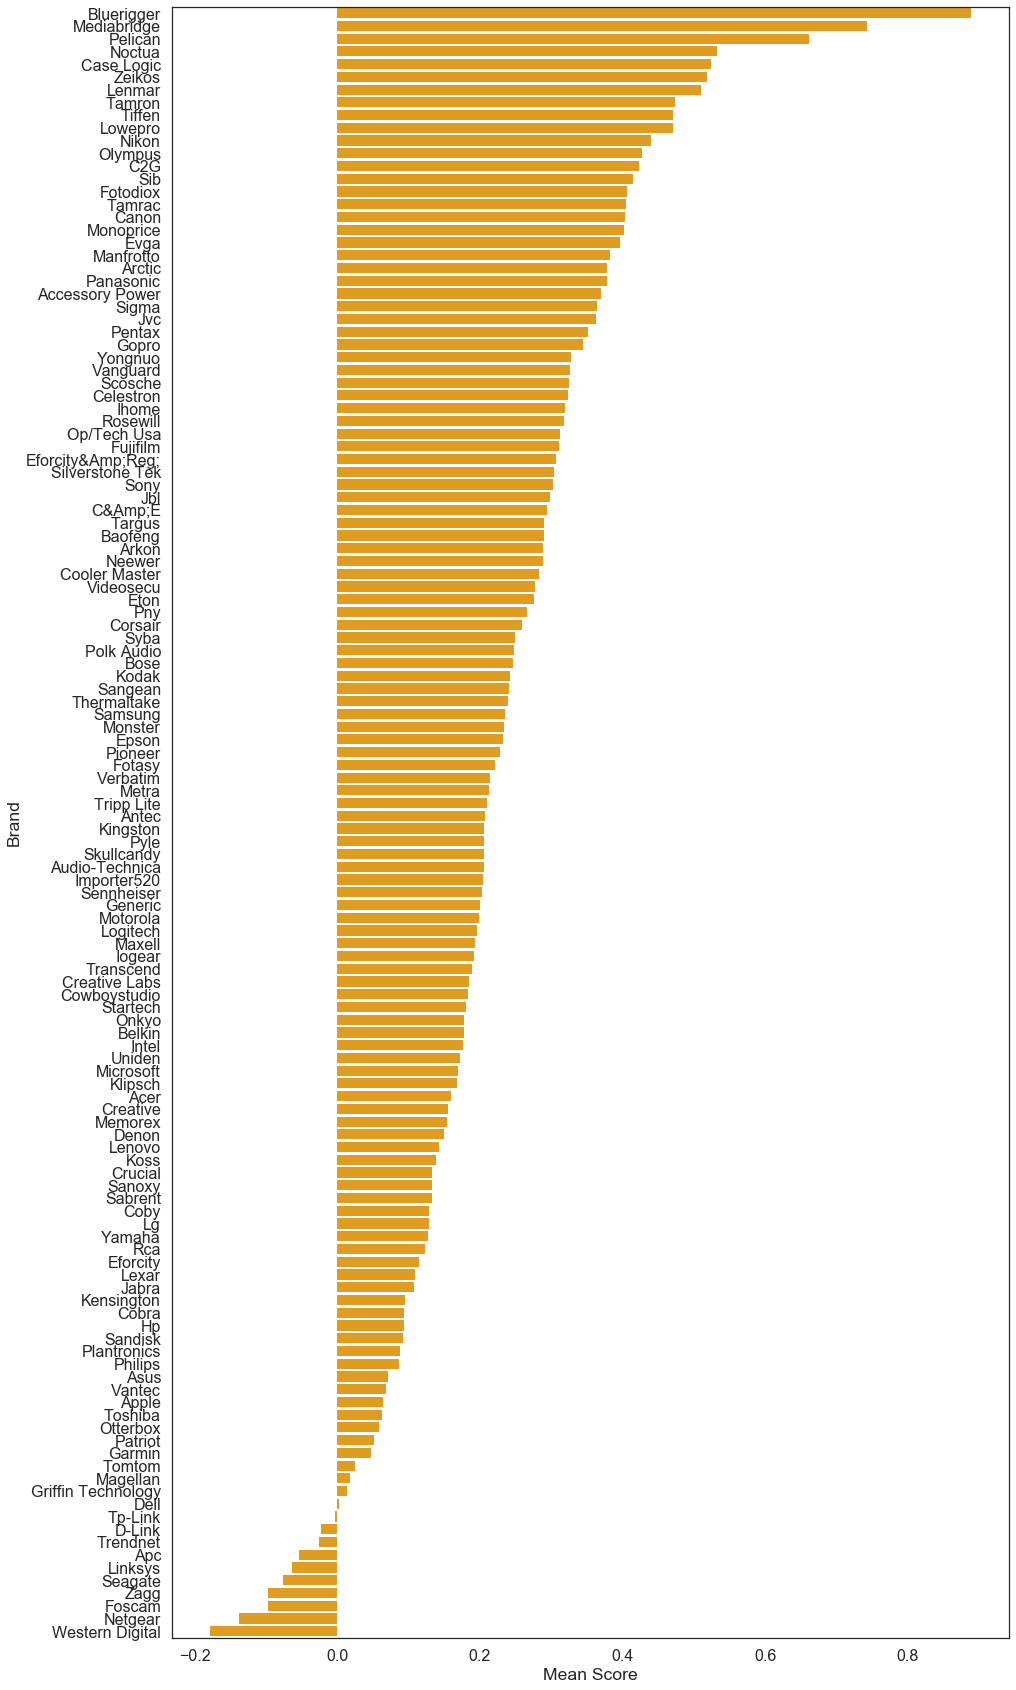

In [41]:
fig, ax = pyplot.subplots(figsize=(15,30))
sns.barplot(y="Brand",x='Mean Score', ax = ax,orient='h',data=df_brand_rank.sort_values('Mean Score',ascending=False),color = "orange")
plt.show()

We can plot the different mean scores of some famous brands: 

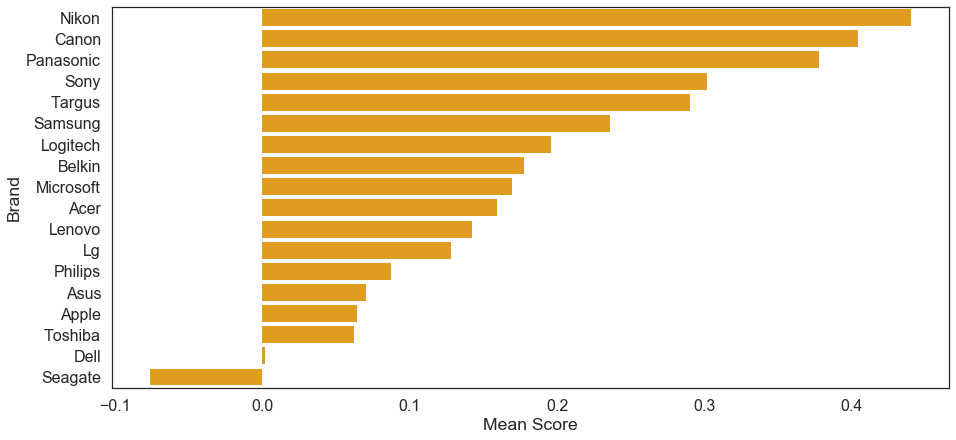

In [42]:
fig, ax = pyplot.subplots(figsize=(15,7))

df_big_brand_rank = df_brand_rank[df_brand_rank['Brand'].isin(big_brands)]
sns.barplot(y="Brand",x='Mean Score', ax = ax,orient='h',data=df_big_brand_rank.sort_values('Mean Score',ascending=False),color = "orange")
plt.show()

## Brand characteristics

As explained at the beginning of this section, if a collocation appears in several different products manufactured by the same brand, we associate the collocation directly to the brand.

As always, we start by defining the helper function:

In [43]:
def getCharacteristics(words,isBigram,threshold = 3):
    """Return the characteristics from the list of bigrams that appear more than threshold.
    """
    res = []
    for w in words:
        if isBigram:
            ((a,b),num) = w
            res.append((a + ' ' + b).lower())
        else:
            (a,num) = w
            res.append(a.lower())
        
    res = list(set([(i,res.count(i)) for i in res if res.count(i) >= threshold]))
    res.sort(key=lambda tup: tup[1],reverse=True)
    
    return " / ".join("(%s,%s)" % tup for tup in res) if len(res) > 0 else np.nan

And we associate to each brand the recurring collocations on its products

In [44]:
# Group by brand
f = {'bigrams':'sum','rawAdjectives':'sum'}

df_brand_characteristics = df_final[['brand','bigrams','rawAdjectives']].groupby(['brand']).agg(f)
df_brand_characteristics = df_brand_characteristics.reset_index()

# Make sure to have unique characteristics and existing brand
df_brand_characteristics['bigramCharacteristics'] = df_brand_characteristics.apply(lambda x : getCharacteristics(x['bigrams'],isBigram = True), axis=1)
df_brand_characteristics['adjetiveCharacteristics'] = df_brand_characteristics.apply(lambda x : getCharacteristics(x['rawAdjectives'],isBigram = False), axis=1)

# Remove null bigrams and ajectives
df_brand_characteristics = df_brand_characteristics[pd.notnull(df_brand_characteristics['bigramCharacteristics'])]
df_brand_characteristics = df_brand_characteristics[pd.notnull(df_brand_characteristics['adjetiveCharacteristics'])]

df_big_brand_characteristics = df_brand_characteristics[df_brand_characteristics['brand'].isin(big_brands)][['brand','bigramCharacteristics','adjetiveCharacteristics']]

Below are shown the result of the brand characterisation for some of the most famous brands:

In [45]:
display(df_big_brand_characteristics)

,brand,bigramCharacteristics,adjetiveCharacteristics
18,Acer,"(great monitor,3) / (most people,3)","(good,23) / (great,21) / (much,21) / (other,19..."
63,Amd,"(dual core,6) / (high settings,3) / (most game...","(great,15) / (much,14) / (good,13) / (new,13) ..."
89,Apple,"(high quality,12) / (new ipod,10) / (much fast...","(great,75) / (new,74) / (good,72) / (other,70)..."
111,Asus,"(dead pixels,19) / (high quality,16) / (dead p...","(great,118) / (good,111) / (other,109) / (much..."
163,Belkin,"(well made,30) / (high quality,29) / (good qua...","(good,179) / (great,175) / (other,173) / (much..."
263,Canon,"(low light,97) / (wide angle,55) / (full frame...","(good,243) / (great,241) / (other,228) / (much..."
377,Dell,"(dead pixels,6) / (original dell,6) / (good pr...","(great,57) / (good,56) / (new,48) / (other,47)..."
823,Lenovo,"(full size,5) / (full windows,3) / (high resol...","(good,31) / (other,29) / (great,27) / (much,26..."
830,Lg,"(optical cable,6) / (flat screen,4) / (great p...","(great,33) / (good,33) / (other,32) / (most,29..."
846,Logitech,"(high quality,50) / (good sound,26) / (full si...","(great,218) / (other,217) / (good,217) / (much..."


### Brand characteristics - Visualization

We prepared a word cloud visualisation to better see the apparition frequency of the collocations. This visualisation requires quite a few helper functions, which are implemented below:

In [46]:
def getDictOfFreq(brands):
    """
    Obtain a dictionnary from the characteristics of brands
    """
    freq = []
    for i in range(len(brands)):
        freq.append(df_brand_characteristics[df_brand_characteristics['brand'] == brands[i]][['bigramCharacteristics']].values[0])
    freq = [elem.split(' / ') for brand_elem in freq for elem in brand_elem]   
    
    res = []
    
    for i in range(len(freq)):
        for j in range(len(freq[i])):
            elem = freq[i][j]
            elem = elem.replace(')','').replace('(','').split(',')
            
            w,n = elem
            
            res.append((w+str(i),int(n)))
            
    return {k:v for k, v in res}
    
def colorBrand(elem):
    """
    Color Function that map each brand to a specific color.
    """
    ((word,freq),size,pos,orientation,color) = elem 
    newColor = colors[int(word[len(word)-1])]
    return ((word[:len(word)-1],freq),size,pos,orientation,newColor)

def colorSentiment(elem,positiveColor,negativeColor):
    """
    Color Function that map each characteristics to a sentiment and a specific color.
    """
    ((word,freq),size,pos,orientation,color) = elem 
    newColor = negativeColor if getPredictionString(word) == -1 else positiveColor
    return ((word,freq),size,pos,orientation,newColor)

def drawWordCloudBrand(brands,colors):
    """
    Draw the brands characteristics using colors such that each characteristics of brand b is the same color c.
    Colors and brands need to be the same length.
    """
    # Generate a word cloud image
    wordcloud = WordCloud(background_color = 'White',height = 1000,width = 1000).generate_from_frequencies(getDictOfFreq(brands))

    wordcloud.layout_ = [colorBrand(elem) for elem in wordcloud.layout_]
    pyplot.imshow(wordcloud, interpolation='bilinear')

    patches = []
    for i in range(len(brands)):
        patches.append(mpatches.Patch(color=colors[i], label=brands[i]))
    # Put a legend to the right of the current axis
    pyplot.legend(loc='center left', bbox_to_anchor=(1, 0.5),handles=patches)
    
    pyplot.axis("off")
    pyplot.show()
    
def drawWordCloudSentiment(brand,positiveColor = "mediumseagreen",negativeColor = "tomato"):
    """
    Draw the characteristics of the brand b, each characteristic c is either a positive or a negative one,
    and will have a repsectively the color positiveColor or negativeColor.
    """
    # Generate a word cloud image
    freq = (df_brand_characteristics[df_brand_characteristics['brand'] == brand][['bigramCharacteristics']].values[0][0])
    freq = freq.split(' / ')
    freq = [elem.replace(')','').replace('(','').split(',') for elem in freq]   
    freq = [(w,int(n)) for w,n in freq]
    wordcloud = WordCloud(background_color = 'White',height = 1000,width = 1000).generate_from_frequencies(dict(freq))
    wordcloud.layout_ = [colorSentiment(elem,positiveColor,negativeColor) for elem in wordcloud.layout_]
    pyplot.imshow(wordcloud, interpolation='bilinear')

    patches = []
    patches.append(mpatches.Patch(color=positiveColor, label="Positive sentiment"))
    patches.append(mpatches.Patch(color=negativeColor, label="Negative sentiment"))

    # Put a legend to the right of the current axis
    pyplot.legend(loc='center left', bbox_to_anchor=(1, 0.5),handles=patches)
    
    pyplot.axis("off")
    pyplot.show()

We are now ready to draw the word cloud for some famous camera brands:

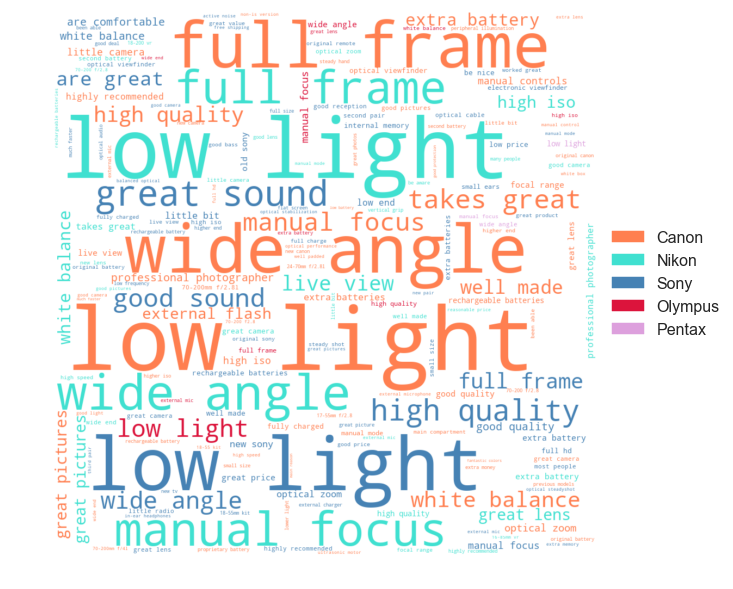

In [47]:
brands_camera = ['Canon','Nikon','Sony','Olympus','Pentax']
colors = ['coral','turquoise','steelblue','crimson','plum']

drawWordCloudBrand(brands_camera,colors)

We will now draw the word cloud of some famous computer brands:

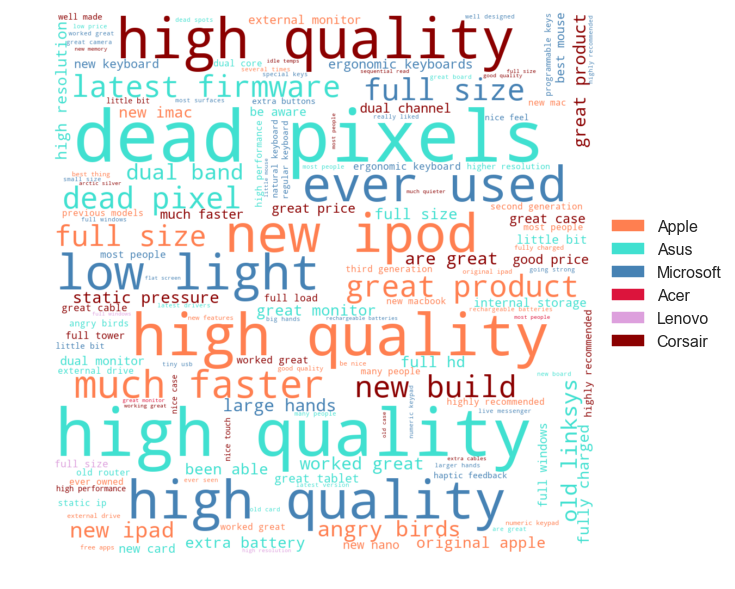

In [51]:
brands_computer = ['Apple','Asus','Microsoft','Acer','Lenovo','Corsair']
colors = ['coral','turquoise','steelblue','crimson','plum','darkred']

drawWordCloudBrand(brands_computer,colors)

We will now draw the word cloud of Logitech:

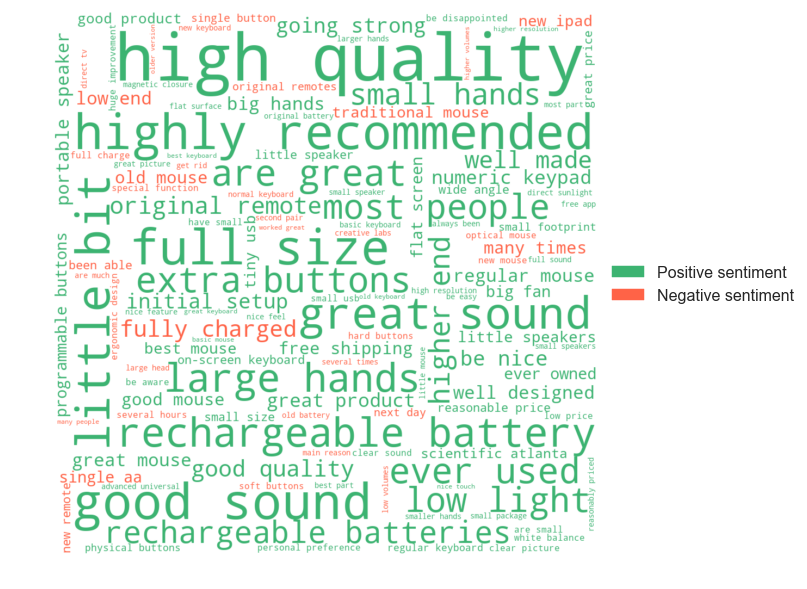

In [52]:
drawWordCloudSentiment("Logitech")

We will now draw the word cloud of Asus. Note how certain products were labelled as being of high quality while at the same time many users complained about dead pixels on their screens !

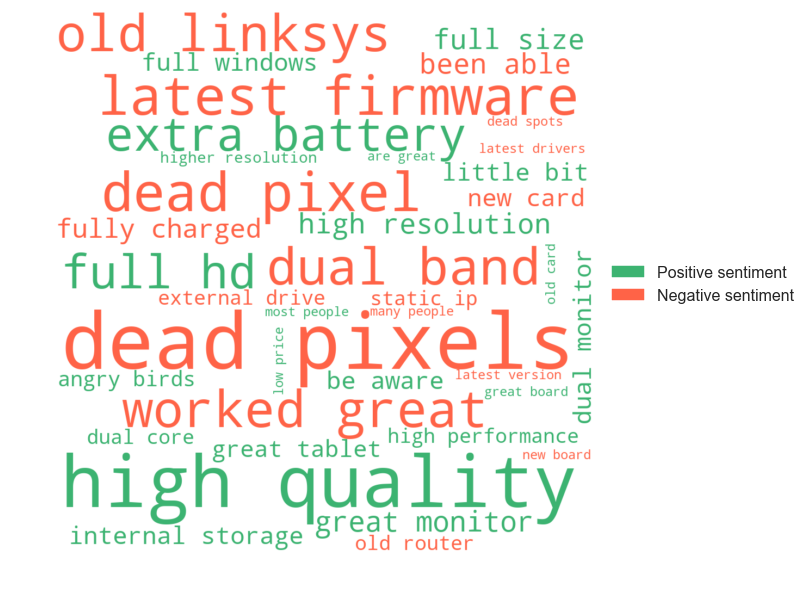

In [50]:
drawWordCloudSentiment("Asus")

We see that there seems to be some mistakes, for example in 'worked great' as we categorized it as a negative sentiment. We noted that those mistakes where due to the fact that most of the time (in our case there is 1900 negative reviews and 1400 positive reviews with this bigram) it was used as "it worked great for 2 days". Hence it's logical that it induce a negative sentiment even if intuitively it shouldn't.

# Possible improvements
**<a href="#Table-of-Contents">Back to table of contents</a>**

Bigram collocations can indeed be used to retrieve basic properties about the products. However, the pipeline tend to also capture a lot of "noise" in the sense that there are many bigram that are not of any particular interest for our study such as "dual core", "angry birds". It could be interesting to see if more advanced filtering techniques are able to reduce those occurrences.

At the present time, the pipeline does not differenciate between users when extracting collocations. This could allow malicious users to take advantage of the system by crafting reviews containing arbitrary collocations with high PMI and likelihood scores. However, we believe it is not a hard task to rectify this behaviour. A limit on collocations per user and review should handle most of the malicious cases.

Finally, bigrams are quite limited in the amount of information they can capture. Some state-of-the-art NLP techniques, which were unfortunately out of the scope of this project, can effectively detect part properties on product and captures nuances such as: "This car is fantastic, except at high speeds where is becomes noisy". It will definitely be interesting to see practical applications of those advanced techniques.

# Conclusion
**<a href="#Table-of-Contents">Back to table of contents</a>**

In this project we have successfully extracted from user reviews basic characteristics about the reviewed products. Those characteristics included appreciation of quality and performance, as well as the presence of special parts. We have been able to attribute to each characteristic a positivity score describing the reviewer's sentiment. In addition to its informative value, the positivity score was used to rank and assign characteristics to brands to observe how its product are perceived by the customers. The pipeline developed this way allows feeding fresh data to the model to update products and brands scores. In addition, the pipeline is not restricted to electronic products and can be applied to virtually any category. With a bit more tuning in the collocation extraction and filtering, this process could have very practical real-world applications on most electronic commerce platforms.